**The concept here is to create an algorithm that simulates the natural erosion of terrain.**

First we import some modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

The first stage here is to produce some form of smoothing algorithm. This will simulate air smoothing in the absence of any other smoothing effect. It can also be used to simulate glaciation.

This requires two functions. The deposition function looks at the gradient between a given pixel and the surroundings. If the pixel is above the surrounding pixels, this is negative (erosion rather than deposition). Vice versa if the cell is below the surroundings (deposition).

In [2]:
def depo_func(J):
    ##takes an array of terrain heights and returns the deposition rate
    
    ##Initialise arrays and lists
    J=np.array(J)
    X0=[]
    x1=[]
    
    #Parse through dataset
    for i in range(len(J)):
        for j in range(len(J[0])):
            
            #initialise array x; these are the heights of pixels surrounding a given pixel in an array.
            x=[]
            
            #Now we introduce boundary conditions. If i is on the edge of the area of interest, we will get an error message
            #This code makes exceptions to eliminate these errors
            
            if i==0:
                x.append(0)
                if j==0:
                    x.append(0)
                    x.append(J[1,0])
                    x.append(J[0,1])
                elif j==len(J[0])-1:
                    x.append(0)
                    x.append(J[0,j-1])
                    x.append(J[1,j])
                else:
                    x.append(J[0,j-1])
                    x.append(J[0,j+1])
                    x.append(J[1,j])
            elif i==len(J)-1:
                x.append(0)
                if j==0:
                    x.append(0)
                    x.append(J[i-1,0])
                    x.append(J[i,1])
                elif j==len(J[0])-1:
                    x.append(0)
                    x.append(J[i,j-1])
                    x.append(J[i-1,j])
                else:
                    x.append(J[i,j-1])
                    x.append(J[i,j+1])
                    x.append(J[i-1,j])
            elif j==0:
                x.append(0)
                x.append(J[i-1,0])
                x.append(J[i+1,0])
                x.append(J[i,1])
            elif j==len(J[0])-1:
                x.append(0)
                x.append(J[i-1,j])
                x.append(J[i+1,j])
                x.append(J[i,j-1])
            ###This is the code for the majority of pixels now that we know that pixel is not on the edge of the area
            else:
                x.append(J[i,j+1])
                x.append(J[i+1,j])
                x.append(J[i,j-1])
                x.append(J[i-1,j])
            
            #Find the mean difference between this pixel and the average of surrounding pixels. Is it positive or negative?
            X=np.mean(x)
            X= X-J[i,j]
            
            ##append this to the arrays to produce a 2D array of deposition value for each pixel.
            X0.append(X)
        x1.append(X0)
        X0=[]
    
    ##return the 2D array.
    return(x1)

In [3]:
def erosion_func(J,erosion_rate):
    ##takes an array of terrain heights and returns the eroded landscape by using the deposition function
    ##the erosion rate changes how powerful the erosion is and must be tuned
    
    #call depo function
    x1=depo_func(J)
    x1=np.array(x1)
    J=np.array(J)
    
    #initialise lists to produce output 2D array
    o=[]
    O=[]
    
    ##parse through the terrain and calculate the height at the next timestep
    for i in range(len(J)):
        for j in range(len(J[0])):
            o.append(J[i,j]+x1[i,j]*erosion_rate)#erosion rate multiplies the rate of erosion/deposition
        O.append(o)
        o=[]
    return(O)

Now, we can see how well our smoothing function does when faced with a given seed for erosion to start. The next cell produces a random 100x100 seed.

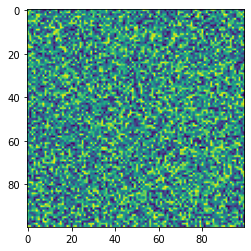

In [4]:
J=np.random.randint (0,100,(100,100))##all values between 0 and 100 to start.
J=np.array(J)
plt.imshow(J)
plt.show()

Now we apply our Deposition function. This picks out the prominent points (making them negative) and antiprominent points (making them positive).

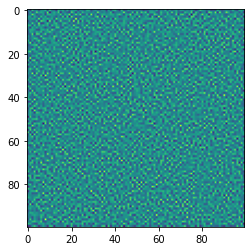

In [5]:
x1=depo_func(J)
plt.imshow(x1)
plt.show()

We now run our Erosion function to find the next stage. There is not much difference in one time step, so we will run over a for loop next with 100 iterations.

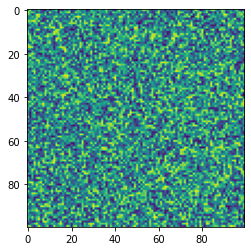

In [6]:
O=erosion_func(J,0.1)
plt.imshow(O)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.30it/s]


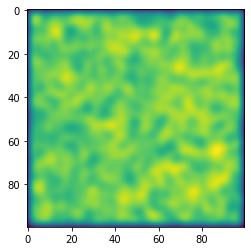

In [7]:
for i in tqdm(range(100)):
    O=erosion_func(J,0.1)
    J=O
plt.imshow(J)
plt.show()

As you can see, there is now a clear difference from the first seed. We can also portray this on a contour plot:

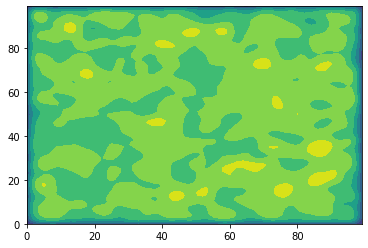

In [8]:
plt.contourf(np.flip(np.flip (J,axis=1)))
plt.show()

And on a 3D plot!

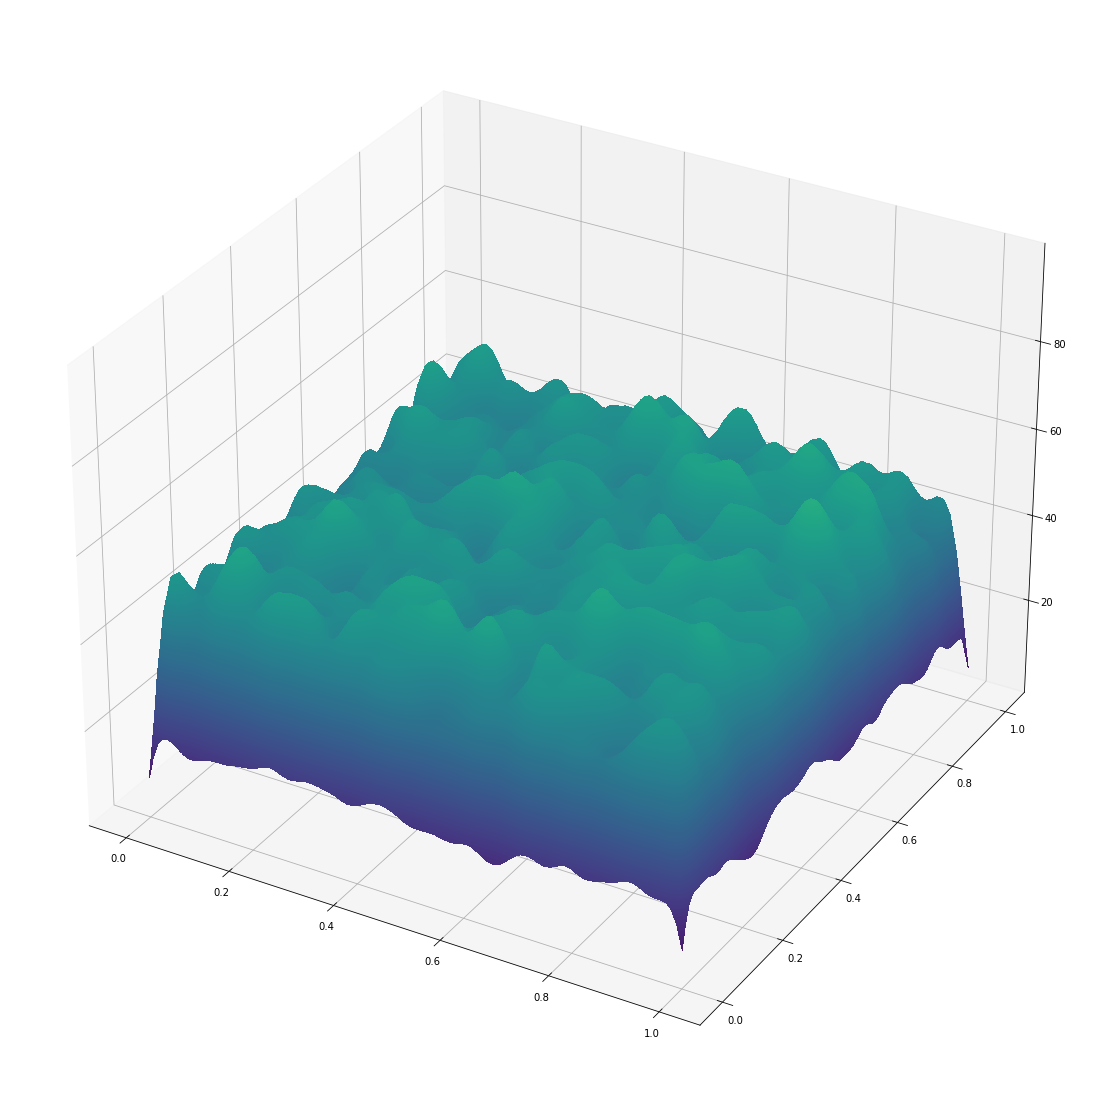

In [9]:
from mpl_toolkits.mplot3d import Axes3D

xx,yy=np.meshgrid(np.linspace(0, 1, len(J[0])), np.linspace(0, 1, len(J)))
fig = plt.figure(figsize=(30, 20))
ax = plt.axes(projection = '3d')
ax.contourf(xx,yy,J,levels=np.linspace(0,100,1000))
plt.show()

**Incorporating River Erosion**

Now we are going to use river erosion to simulate a more wet environment, with significant water present. The first step is to find out where water is likely to flow if it lands on a given square. This is found by figuring out which direction is lowest. It then returns the coordinates of the next point downhill!

In [10]:
def whichdirectionislowest(J,coordinate_storage):
    ###takes in location in array, and calculates coordinates of lowest neighbour
    ###returns new coordinates
    
    #make sure J is an array
    J=np.array(J)
    
    #calculate current height
    currentheight=J[coordinate_storage[0],coordinate_storage[1]]
    
    #if we have a pixel on the edge of the simulation area, we can't calculate the lowest adjacent coordinates-
    #they are out of our range! we therefore filter out these pixels.
    if coordinate_storage[0]==0 or coordinate_storage[1]==0 or coordinate_storage[0]==len(J)-1 \
    or coordinate_storage[1]==len(J[0])-1:
        pass
    
    #If it is not on the edge of the array, carry out this section of code:
    else:
        ##we are choosing the lowest number nearby by finding the minimum value in this list:
        lowest=[]
        
        #this value will be in one of these three rows around the pixel:
        row_1=J[coordinate_storage[0]-1]
        row_2=J[coordinate_storage[0]]
        row_3=J[coordinate_storage[0]+1]
        
        #specifically it will be in one of these 4 pixels adjacent to our pixel:
        lowest.append(row_1[coordinate_storage[1]])
        lowest.append(row_2[coordinate_storage[1]+1])
        lowest.append(row_2[coordinate_storage[1]-1])
        lowest.append(row_3[coordinate_storage[1]])
        
        #we now have our array of surrounding values.
        #if our current value is lower than the surrounds, we won't have any river erosion.
        if min(lowest)>currentheight:
            pass
        
        ##now we figure out which direction is lowest:
        elif lowest[0]==min(lowest):
            coordinate_storage=[coordinate_storage[0]-1,coordinate_storage[1]]
        elif lowest[1]==min(lowest):
            coordinate_storage=[coordinate_storage[0],coordinate_storage[1]+1]
        elif lowest[2]==min(lowest):
            coordinate_storage=[coordinate_storage[0],coordinate_storage[1]-1]
        elif lowest[3]==min(lowest):
            coordinate_storage=[coordinate_storage[0]+1,coordinate_storage[1]]
            
    #return our next pixel:
    return(coordinate_storage)


We then trace the river as it flows downhill, and build an array of how strong erosion is at that part of the path. I have added some parameters to allow you to decide whether to apply steepness (if true, the river erodes faster when flowing down a steeper gradient).

In [11]:
def rivertracer1(J,coordinate_storage,steepness=True):
    #traces the line of a river from coordinate in 2D array.
    
    ##define parameters and make sure J is an array
    J=np.array(J)
    accumulator=0
    currentheight=J[coordinate_storage[0],coordinate_storage[1]]
    
    ##This initialises the array of river path
    X1=np.zeros((len(J),len(J[0])))
    X1=np.array(X1)
    
    multiplier=1##this parameter is used to multiply river erosion by the steepness of that part of the river bed
    
    while multiplier>0 and currentheight>0:###when current height=0, we assume the river has reached the water table
        ###if multiplier=0, this means that newheight=currentheight for the previous iteration. The river stops flow.
        ###find the coordinates of the next lowest location and the height of this coordinate
        coordinate_storage2=whichdirectionislowest(J,coordinate_storage)
        newheight=J[coordinate_storage2[0],coordinate_storage2[1]]
        
        ##we need the ''current height' parameter for if steepness is true
        currentheight=J[coordinate_storage[0],coordinate_storage[1]]
        
        if steepness:
            multiplier=currentheight-newheight #muliplier defined as the difference between the two adjacent pixels
            
            ##set the erosion value at these coordinates to multiplier+1. +1 added so there is at least some erosion at all
            ##locations.
            X1[coordinate_storage[0],coordinate_storage[1]]= (multiplier+1)
        else:
            X1[coordinate_storage[0],coordinate_storage[1]]= 1
            
        coordinate_storage=coordinate_storage2#redefine coordinate_storage
        
        
    ##stops erosion at end of river path. Now that the while loop has ended, this resets the previous river erosion to zero
    ##the river has stopped flowing so there will be no erosion at the end point
    X1[coordinate_storage[0],coordinate_storage[1]]=0
    
    #return array containing path
    return(X1)

Now we are ready to define a river erosion function, where we find the path of EVERY water flow from Every coordinate and calculate the erosion. Rivers quickly become clear as areas of high erosion.

In [12]:
def rivererosion(J,rivererosionrate):
    ###returns a completed, RIVER eroded version of J with erosion rate. addition parameter means more erosion
    ##'further down'; might not be needed, set to 0
    J=np.array(J)
    X=np.zeros((len(J),len(J[0])))
    
    ##Do rivertracer at every point and sum the arrays
    for i in range(len(J)):
        for j in range(len(J[i])):
            XD=rivertracer1(J,[i,j])
            X+=XD
    
    ##calculate new terrain height
    D=J-X*rivererosionrate
    
    ##make sure terrain doesn't go more than 2 metres below water table- here deposition will be high enough to offset erosion
    D=np.clip(D, -2, 100000)
    return(D)

Demonstration of the rivertracer function: steeper slope leads to stronger erosion if steepness=true

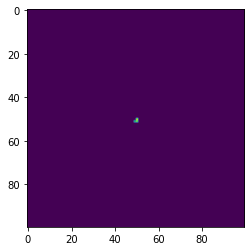

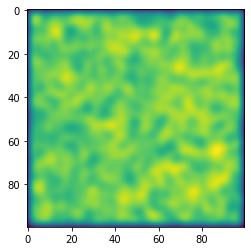

In [13]:
plt.imshow(rivertracer1(J,[int(np.round(len(J)/2)),int(np.round(len(J[0])/2))]))
plt.show()
plt.imshow(J)
plt.show()

Now, the rivererosion function adds all of these effects together to produce this new map of terrain height.

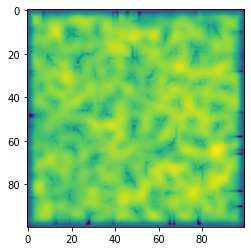

In [14]:
I=rivererosion(J,0.1)
plt.imshow(I)

**Bringing it all together: both smoothing and river erosion**

Now we can add the two together. First, we need to make a seed. Here is just one seed I have tried:

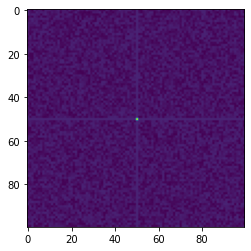

In [15]:
##Seed creation

#Random numbers
J=np.random.randint (0,10000,(100,100))
J=np.array(J)

#Gradient
for i in range(len(J)):
    for j in range(len(J[0])):
        J[i,j]=J[i,j]+i/10

#Slices/ridges
J[:,50]=10000
J[50,:]=10000

#Peak in center
J[50,50]=100000

plt.imshow(J)
plt.show()

I decided to smooth first and then use river erosion after, to give a good starting point for the river erosion.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.52it/s]


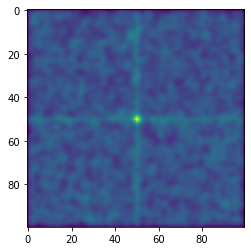

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


In [16]:
####INCORPORATION. smoothing followed by rivers

##Smoothing: 40 iterations
for i in tqdm(range(40)):
    J=erosion_func(J,0.1)

#Display
plt.imshow(J)
plt.show()

##Smoothing and river erosion: 100 iterations
for i in tqdm(range(100)):
    J=erosion_func(J,0.2)
    J=rivererosion(J,0.02)


Let's see the results!

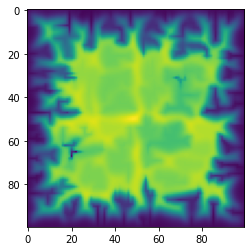

In [17]:
##Plot it!

plt.imshow(J)
plt.show()

Finally, we can see the results in different formats.

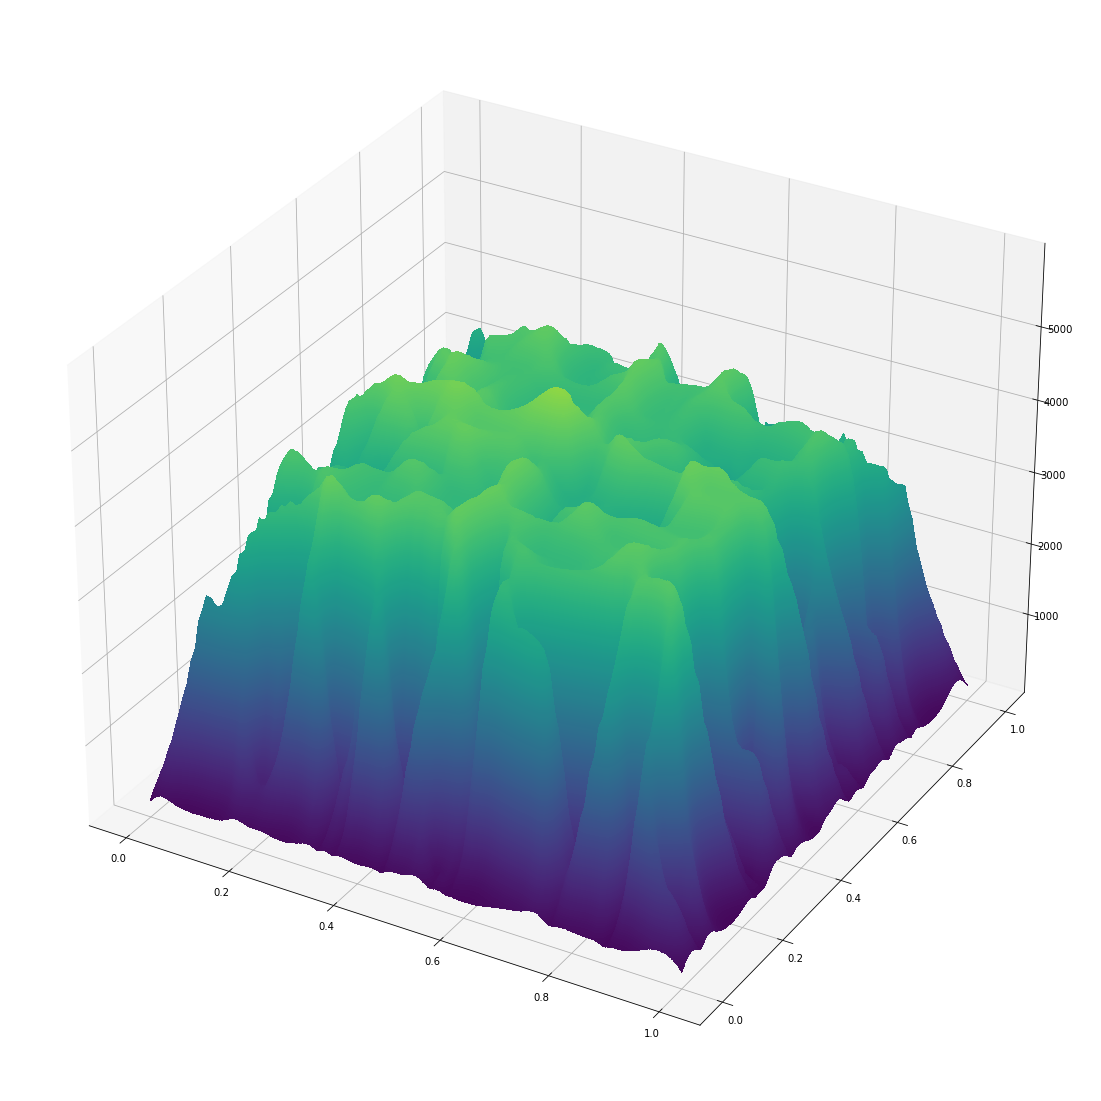

In [18]:
from mpl_toolkits.mplot3d import Axes3D

xx,yy=np.meshgrid(np.linspace(0, 1, len(J[0])), np.linspace(0, 1, len(J)))
fig = plt.figure(figsize=(30, 20))
ax = plt.axes(projection = '3d')
ax.contourf(xx,yy,np.flip(np.flip (J,axis=1)),levels=np.linspace(0,6000,1000))
plt.show()

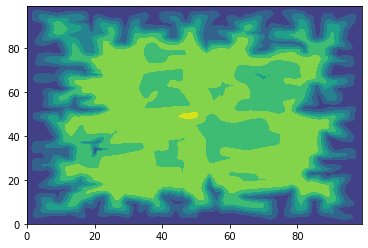

In [19]:
plt.contourf(np.flip(np.flip (J,axis=1)))
plt.show()